### 文件结构
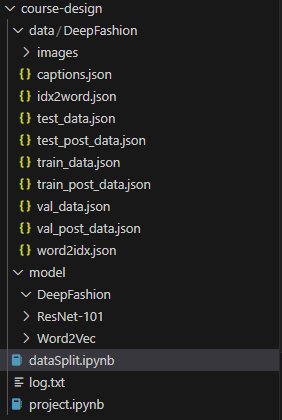

In [ ]:
import os
import re
import json
import random 
from collections import defaultdict, Counter
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.distributed as dist
from torch.utils.data import DataLoader

In [ ]:

def create_dataset(dataset='DeepFashion',
                   min_word_count=5, 
                   max_len=50):
    """
    参数：
        dataset：数据集名称
        min_word_count：仅考虑在数据集中（除测试集外）出现5次的词
        max_len：文本描述包含的最大单词数，如果文本描述超过该值，则截断
    输出：
        两个词典文件： word2idx.json(即vocab）、 idx2word.json
        三个数据集文件： train_data.json、 val_data.json、 test_data.json
    """
    split = ['train', 'val', 'test']
    json_path='./data/%s/captions.json' % dataset
    image_folder='./data/%s/images' % dataset
    output_folder='./data/%s' % dataset

    # 变量初始化
    train_test_split = 0.8 # train、test、val划分比例
    train_val_split = 0.9
    vocab = Counter() # 统计词频
    caption = []
    data_dict = {} # 统计中间数据
    image_paths = defaultdict(list)
    image_captions = defaultdict(list)

    # 读取json文件
    with open(json_path, 'r') as j:
        data = json.load(j)
    data_items = list(data.items())
    data_items = [(k, v) for k, v in data_items if v] # 删除value为空的项
    random.shuffle(data_items)
    train_data = data_items[:int(len(data_items) * train_test_split)] # 划分训练测试数据
    test_data = data_items[int(len(data_items) * train_test_split):]
    # 更新vocab
    for item in train_data:# vocab不统计test集的词汇
        token = item[1].split()
        vocab.update(token)

        if len(token) <= max_len:
            caption.append(token) # 保存长度小于max_len处的token
    
    random.shuffle(train_data)
    train_data = train_data[:int(len(train_data) * train_val_split)] # 划分训练验证数据
    val_data = train_data[int(len(train_data) * train_val_split):]

    # 存储切分后的json文件
    with open(os.path.join(output_folder, 'train_data.json'), 'w') as f:
        json.dump(dict(train_data), f, indent=4)
    with open(os.path.join(output_folder, 'val_data.json'), 'w') as f:
        json.dump(dict(val_data), f, indent=4)
    with open(os.path.join(output_folder, 'test_data.json'), 'w') as f:
        json.dump(dict(test_data), f, indent=4)

    # 读取切分后的json文件
    for s in split:
        with open(os.path.join(output_folder, '%s_data.json' % s), 'r') as f:
            data_dict[s] = json.load(f)
    
    # 整理数据集,划分图片和描述
    for s in split:
        for item in data_dict[s].items():
            if Image.open(os.path.join(image_folder, item[0])):
                image_paths[s].append(os.path.join(image_folder, item[0]))
                image_captions[s].append(item[1])
    
    # 统计词频
    words = [w for w in vocab.keys() if vocab[w] > min_word_count] # 如果词频过小则删除
    vocab = {k: v + 4 for v, k in enumerate(words)} # word2idx词典
    vocab['<pad>'] = 0
    vocab['<bos>'] = 1
    vocab['<eos>'] = 2
    vocab['<unk>'] = 3
    idx2word = {int(v): k for k, v in vocab.items()} # idx2word词典
    
    # 存储word2idx、 idx2word词典
    with open(os.path.join(output_folder, 'word2idx.json'), 'w') as f:
        json.dump(vocab, f, indent=4)
    with open(os.path.join(output_folder, 'idx2word.json'), 'w') as f:
        json.dump(idx2word, f, indent=4)

    # 读取构建好的词典
    with open(os.path.join(output_folder, 'word2idx.json'), 'r') as f:
        vocab = json.load(f)
    
    # 编码文本描述
    for s in split:
        images = []
        captions = []
        for item in data_dict[s].items():
            image_path = os.path.join(image_folder, item[0])
            if Image.open(image_path):
                images.append(image_path)
                caption = item[1].split()
                if len(caption) > 48:
                    caption = caption[ :48]
                caption = [vocab['<bos>']] + [vocab[w] if w in vocab else '<unk>' for w in caption] + [vocab['<eos>']]
                captions.append(caption)
        
        # 校验合法性
        assert len(images) == len(captions)

        # 打印一个实例用于观察
        if images and captions:
            print(f"Example from {s} set:")
            print(f"Image path: {images[0]}")
            print(f"Caption: {captions[0]}")
            

        data = {'IMAGES': images, 'CAPTIONS': captions}
        with open(os.path.join(output_folder, '%s_data.json' % s), 'w') as f:
            json.dump(data, f, indent=4)
        
create_dataset()